#Install surprise

In [76]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3096305 sha256=91b0b818e331cef3eb598b0294f12911610c57d029adac4ac4b0f6e35acdc1df
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


#Importing Drive

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


#Import libraries

In [220]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
import seaborn as sns
from surprise.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
import pickle

#Reading data

In [110]:
ratings=pd.read_csv("/content/ratings.csv")
movies=pd.read_csv("/content/movies.csv")

In [111]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [112]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#**Get insights from data**

#top used ratings

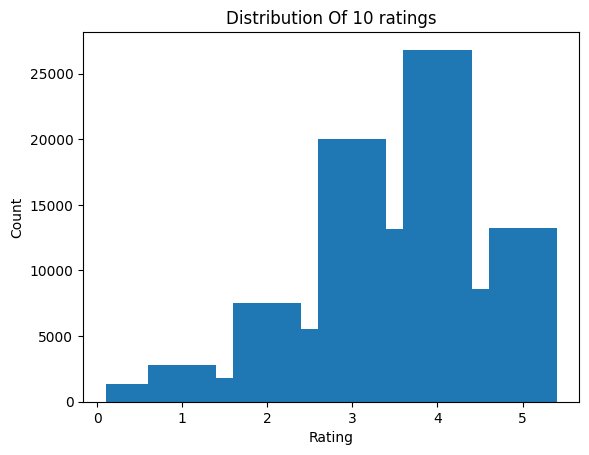

In [113]:
df = ratings['rating'].value_counts().sort_index(ascending=False)
fig, ax = plt.subplots()
ax.bar(df.index, df.values)
ax.set_title('Distribution Of {} ratings'.format(df.shape[0]))
ax.set_xlabel('Rating')
ax.set_ylabel('Count')

plt.show()

#Most movies have numberr of ratings

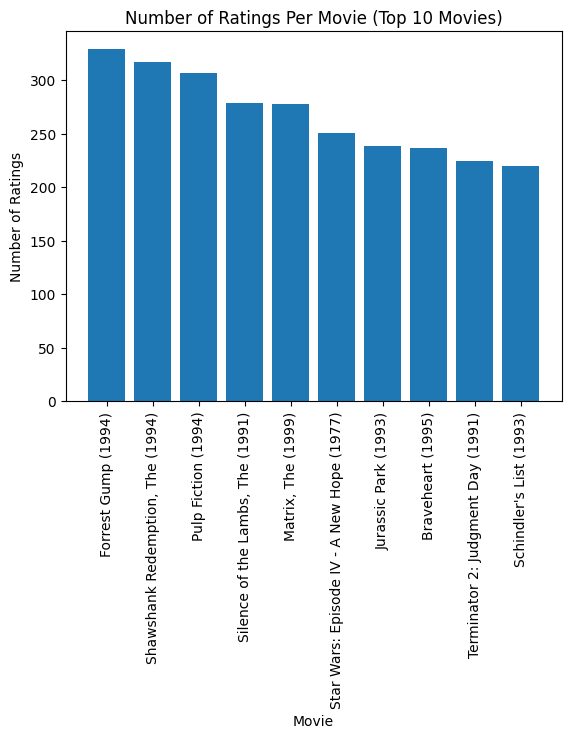

In [114]:
# Assuming the data is in DataFrames named 'ratings' and 'movies'
ratings_per_movie = ratings.groupby('movieId')['rating'].count().nlargest(10).sort_values(ascending=False)
top_movies = pd.merge(ratings_per_movie, movies, on='movieId')

fig, ax = plt.subplots()
ax.bar(range(len(top_movies)), top_movies['rating'])

ax.set_title('Number of Ratings Per Movie (Top 10 Movies)')
ax.set_xlabel('Movie')
ax.set_ylabel('Number of Ratings')
ax.set_xticks(range(len(top_movies)))
ax.set_xticklabels(top_movies['title'], rotation='vertical')

plt.show()


#Most users that rated movies

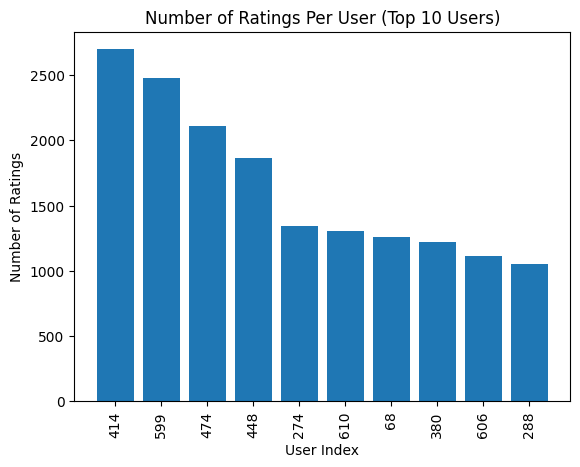

In [115]:
ratings_per_user = ratings.groupby('userId')['rating'].count().nlargest(10).sort_values(ascending=False)

fig, ax = plt.subplots()
ax.bar(range(len(ratings_per_user)), ratings_per_user.values)

ax.set_title('Number of Ratings Per User (Top 10 Users)')
ax.set_xlabel('User Index')
ax.set_ylabel('Number of Ratings')
ax.set_xticks(range(len(ratings_per_user)))
ax.set_xticklabels(ratings_per_user.index, rotation='vertical')

plt.show()

#Utility Matrix

In [116]:
utility_matrix = ratings.pivot(index="movieId",columns="userId",values="rating")
utility_matrix = utility_matrix.fillna(0)

In [117]:
utility_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#similarity matrix

In [118]:
sim_df = pd.DataFrame(cosine_similarity(utility_matrix), index=utility_matrix.index, columns=utility_matrix.index)
sim_df.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
movie_1_similarity_sorted = movie_1_similarity.sort_values(ascending=False)
movie_1_similarity_sorted

movieId
1         1.000000
3114      0.572601
480       0.565637
780       0.564262
260       0.557388
            ...   
92730     0.000000
3942      0.000000
92637     0.000000
3958      0.000000
193609    0.000000
Name: 1, Length: 9724, dtype: float64

#**Model**

#knn (NearestNeighbors)_The used model

In [119]:
model_knn = NearestNeighbors(metric='cosine',algorithm='brute', n_neighbors=6)
model_knn.fit(utility_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

#Get similar Movies

In [140]:
def get_similar_movies(movie_name, top_k):
    movie_id = movies[movies['title'] == movie_name]['movieId'].values[0]
    query_index_movie_ratings = utility_matrix.loc[movie_id, :].values.reshape(1, -1)
    distances, indices = model_knn.kneighbors(query_index_movie_ratings, n_neighbors=top_k+1)

    similar_movies = []
    for i in range(0, len(distances.flatten())):
        if i == 0:
            continue  # Skip the first item, as it is the query movie itself
        indices_flat = indices.flatten()[i]
        similar_movie_id = utility_matrix.iloc[indices_flat, :].name
        similar_movie_row = movies[movies['movieId'] == similar_movie_id]
        similar_movie_name = similar_movie_row['title'].values[0]
        similar_movie_genre = similar_movie_row['genres'].values[0]
        similarity = 1 - distances.flatten()[i]  # Calculate similarity as 1 - distance
        similar_movies.append({'Movie': similar_movie_name, 'Genre': similar_movie_genre, 'Similarity': similarity})

    similar_movies_df = pd.DataFrame(similar_movies)
    return similar_movies_df


In [141]:
get_similar_movies("Toy Story (1995)",10)


,Movie,Genre,Similarity
0,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,0.572601
1,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0.565637
2,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,0.564262
3,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.557388
4,Forrest Gump (1994),Comedy|Drama|Romance|War,0.547096
5,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,0.541145
6,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,0.541089
7,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,0.538913
8,Groundhog Day (1993),Comedy|Fantasy|Romance,0.534169
9,Back to the Future (1985),Adventure|Comedy|Sci-Fi,0.530381


#KNN(surprise)

In [201]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [202]:
k = 10
sim_options = {'name': 'pearson', 'user_based': False}
knn_model = KNNWithMeans(k=k, sim_options=sim_options)

In [203]:
trainset = data.build_full_trainset()

In [204]:
knn_model.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [217]:
def find_similar_movies(movie_name, top_k):
    movie_id = movies[movies['title'] == movie_name]['movieId'].values[0]

    similar_movies = knn_model.get_neighbors(movie_id, k=top_k)

    similar_movie_data = movies[movies['movieId'].isin(similar_movies)][['title', 'genres']]

    similar_movies_df = pd.DataFrame(similar_movie_data)

    return similar_movies_df




In [219]:
find_similar_movies("Back to the Future (1985)", 10)

,title,genres
42,How to Make an American Quilt (1995),Drama|Romance
44,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
52,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance
133,Congo (1995),Action|Adventure|Mystery|Sci-Fi
140,First Knight (1995),Action|Drama|Romance
166,Species (1995),Horror|Sci-Fi
175,"Walk in the Clouds, A (1995)",Drama|Romance
270,Relative Fear (1994),Horror|Thriller
320,"Jungle Book, The (1994)",Adventure|Children|Romance


#**We used the knn model from neighrest neihgboor library because its results are more logical and get best results when it depends only on the movie **

#Saving the first Model

In [221]:
# Save the knn_model as a pickle file
with open('/content/drive/MyDrive/Recommender Systems/project/neighrest_knn.pkl', 'wb') as file:
    pickle.dump(model_knn, file)


#Loading the Model

In [123]:
# Load the saved model using pickle
with open('/content/drive/MyDrive/Recommender Systems/project/model_knn.pkl', 'rb') as file:
    model_knn = pickle.load(file)


#**Thank you**